# Chapter 6: Portfolio Basics

In [2]:
# Core numerical computing
import numpy as np
import pandas as pd

# For financial data
import yfinance as yf       # Lodaing financial data
import empyrical as emp     # Performance metrics

# Book data (pip install "git+https://github.com/dppalomar/pob.git#subdirectory=python")
from pob_python import SP500_stocks_2015to2020, SP500_index_2015to2020

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="darkgrid")

# Optimization
import cvxpy as cp       # interface for convex optimization solvers
#import riskparityportfolio as rpp # installation fails
from scipy.optimize import minimize, LinearConstraint   # for optimization
import warnings
warnings.filterwarnings('ignore')
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('YFinance version: {}'.format(yf.__version__))

NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2
YFinance version: 0.2.65


## Financial datasets
It is not easy to get financial time series for free. One financial data source is [Yahoo Finance](https://finance.yahoo.com/quote/NVDA/history/) that can be consumed parsing the source page in Google Chrome copying the HTML data of the container div element, or more easily through the YFinance Python package. Another data source is [Nasdaq](https://www.nasdaq.com/market-activity/stocks/nvda/historical).

In [7]:
stocks = yf.download(["AAPL", "AMD", "ADI", "A", "MOH", "CVS", "APD", "AA", "CF"], start='2021-10-01', end='2021-12-31')

[*********************100%***********************]  9 of 9 completed


In [8]:
stocks.head()

Price            Close                                                 \
Ticker               A         AA        AAPL         ADI         AMD   
Date                                                                    
2021-10-01  151.454773  47.667316  139.650681  155.883759  102.449997   
2021-10-04  148.114502  47.102249  136.214432  152.987213  100.339996   
2021-10-05  148.765839  46.977745  138.143036  154.021011  101.809998   
2021-10-06  149.368546  45.062241  139.014343  154.654388  103.639999   
2021-10-07  150.992035  45.062241  140.277191  155.520523  106.449997   

Price                                                           High  ...  \
Ticker             APD         CF        CVS         MOH           A  ...   
Date                                                                  ...   
2021-10-01  232.851013  56.194256  73.482216  271.510010  152.920866  ...   
2021-10-04  231.548538  55.826618  73.254959  269.500000  151.944717  ...   
2021-10-05  232.480164  55.541691  73.106369  269.410004  151.439210  ...   
2021-10-06  235.854034  55.008610  72.678070  270.510010  149.961549  ...   
2021-10-07  238.205795  55.753082  73.595848  277.119995  153.091836  ...   

Price             Open   Volume                                        \
Ticker             MOH        A       AA      AAPL      ADI       AMD   
Date                                                                    
2021-10-01  271.209991  1881900  6561200  94639600  3549200  41491600   
2021-10-04  269.359985  1758300  4681700  98322000  5377500  41967100   
2021-10-05  272.079987  1494300  4226400  80861100  2899100  31455200   
2021-10-06  266.980011  1794700  7321800  83221100  2754000  39071700   
2021-10-07  273.700012  1002800  5916600  61732700  2174100  41543100   

Price                                          
Ticker          APD       CF      CVS     MOH  
Date                                           
2021-10-01   877000  7615500  6888400  260700  
2021-10-04  1007000  4170100  4768000  167700  
2021-10-05   970900  4236500  4848600  305600  
2021-10-06  1310200  4244200  5205100  197900  
2021-10-07  1359600  4388700  4262000  168200  

[5 rows x 45 columns]

In [9]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2021-10-01 to 2021-12-30
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, A)      63 non-null     float64
 1   (Close, AA)     63 non-null     float64
 2   (Close, AAPL)   63 non-null     float64
 3   (Close, ADI)    63 non-null     float64
 4   (Close, AMD)    63 non-null     float64
 5   (Close, APD)    63 non-null     float64
 6   (Close, CF)     63 non-null     float64
 7   (Close, CVS)    63 non-null     float64
 8   (Close, MOH)    63 non-null     float64
 9   (High, A)       63 non-null     float64
 10  (High, AA)      63 non-null     float64
 11  (High, AAPL)    63 non-null     float64
 12  (High, ADI)     63 non-null     float64
 13  (High, AMD)     63 non-null     float64
 14  (High, APD)     63 non-null     float64
 15  (High, CF)      63 non-null     float64
 16  (High, CVS)     63 non-null     float64
 17  (High, MOH)     6

In [10]:
stocks['Close'].head()

Ticker,A,AA,AAPL,ADI,AMD,APD,CF,CVS,MOH
Date,,,,,,,,,
2021-10-01,151.454773,47.667316,139.650681,155.883759,102.449997,232.851013,56.194256,73.482216,271.510010
2021-10-04,148.114502,47.102249,136.214432,152.987213,100.339996,231.548538,55.826618,73.254959,269.500000
2021-10-05,148.765839,46.977745,138.143036,154.021011,101.809998,232.480164,55.541691,73.106369,269.410004
2021-10-06,149.368546,45.062241,139.014343,154.654388,103.639999,235.854034,55.008610,72.678070,270.510010
2021-10-07,150.992035,45.062241,140.277191,155.520523,106.449997,238.205795,55.753082,73.595848,277.119995


For this notebook we will use the S&P500 index and the crypto currencies datasets from the book's Python package 

In [11]:
from pob_python import SP500_stocks_2015to2020, cryptos_2017to2021_hourly
# stock S&P500 market data
SP500_stocks_2015to2020.iloc[:, :5].head()

,A,AAL,AAP,AAPL,ABBV
Date,,,,,
2015-01-05,37.7523,51.0467,154.217,24.239,50.8722
2015-01-06,37.1642,50.2556,154.108,24.241,50.6204
2015-01-07,37.6574,50.2272,157.420,24.581,52.6663
2015-01-08,38.7862,50.8430,158.800,25.526,53.2171
2015-01-09,38.5016,49.2891,157.991,25.553,51.7614


In [12]:
# crypto data
cryptos_2017to2021_hourly.iloc[:, :5].head()

,BTC,ETH,ADA,DOT,XRP
Date,,,,,
2021-01-07 09:00:00,37485.61,1204.525106,0.330998,10.005659,0.305133
2021-01-07 10:00:00,37040.38,1183.403101,0.308546,9.677910,0.323733
2021-01-07 11:00:00,37806.57,1201.001309,0.311904,9.823281,0.357990
2021-01-07 12:00:00,37936.25,1227.161815,0.317906,9.966991,0.336457
2021-01-07 13:00:00,38154.69,1218.126633,0.318592,9.882065,0.328512


We plot the stock prices of some of the firms in the dataset

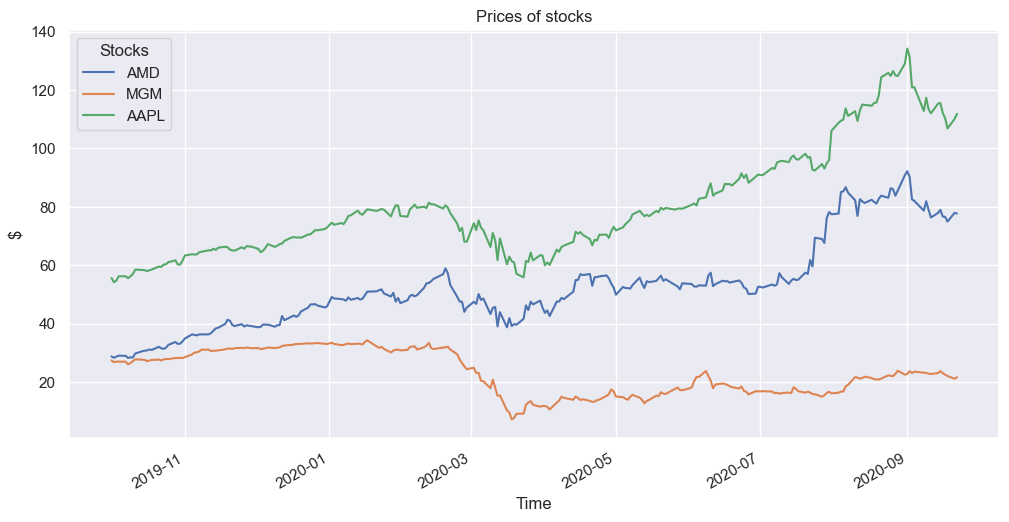

In [25]:
# Plot stock prices
stock_prices = SP500_stocks_2015to2020[["AMD", "MGM", "AAPL"]].loc["2019-10":]
fig, ax = plt.subplots(figsize=(12, 6))
stock_prices.plot(ax=ax)
ax.set_title('Prices of stocks')
ax.set_xlabel('Time')
ax.set_ylabel('$')
ax.legend(title="Stocks")
plt.show()

## Linear returns
We use the DataFrame method [pct_change()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) to calculate the linear returns from the prices, defined as (see p.143)

$$r_t = \frac{p_t - p_{t-1}}{p_{t-1}}$$

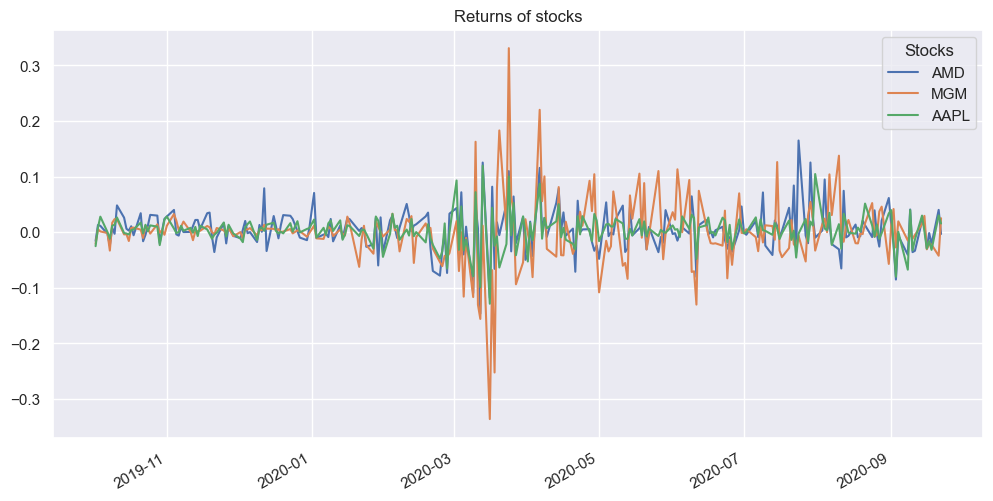

In [14]:
stock_returns = stock_prices.pct_change()
# Plot returns
fig, ax = plt.subplots(figsize=(12, 6))
stock_returns.plot(ax=ax)
ax.set_title('Returns of stocks')
ax.set_xlabel(None)
ax.legend(title="Stocks")
plt.show()

## Cumulative returns
It's fundamental to calculate the cumulative returns of the stocks, that is the change in value of the assets with time. It works like compounding for bonds. The sum of the cumulative returns of all the assets in a portfolio, fully reinvested at each period, represent the *net asset value (NAV)* aka *wealth* (see p.148). The net asset value $NAV_t$, from t=0 to t=T, is defined as

$$NAV_t = NAV_0 \prod_{t=1}^T (1 + r_t)$$

where $NAV_0$ is the initial investment in each asset. If we assume we had bought one unit (share) of each stock paying their prices at the beginning of the time series we can calculate our NAV at the present time

In [19]:
NAV_start = SP500_stocks_2015to2020[["AMD", "MGM", "AAPL"]].loc['2015-01-05']
NAV_start

AMD      2.6600
MGM     19.3206
AAPL    24.2390
Name: 2015-01-05 00:00:00, dtype: float64

In [26]:
cumulative_returns = (1 + stock_returns).cumprod()
NAV = NAV_start * cumulative_returns

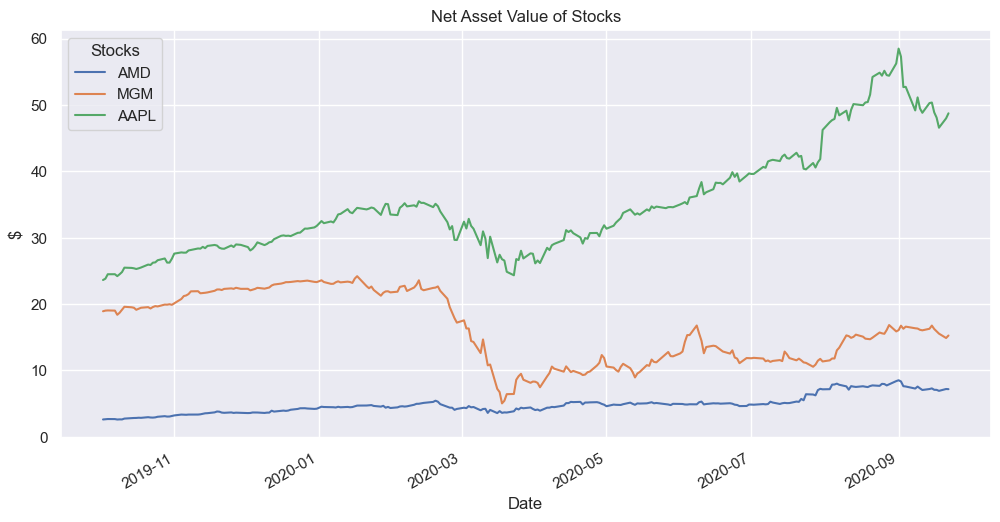

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
NAV.plot(ax=ax)
ax.set_title('Net Asset Value of Stocks')
ax.set_ylabel('$')
ax.legend(title="Stocks")
plt.show()

## Drawdown
The drawdown measures the decline from a historical peak, aka *high-water mark (HWM)*, of the cumulative profit or NAV
$$D_t = HWM_t - NAV_t$$

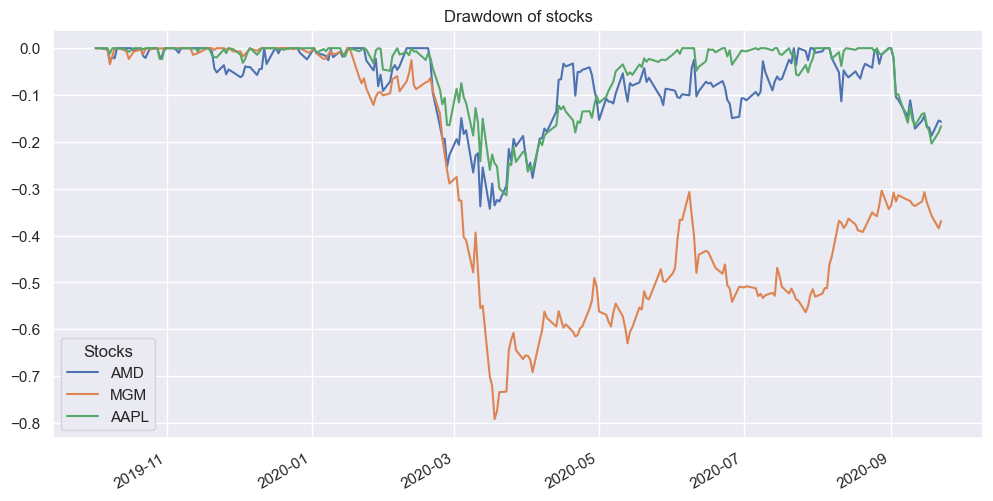

In [29]:
running_max = cumulative_returns.cummax() # HWM
drawdowns = (cumulative_returns - running_max) / running_max
# Plot drawdowns
fig, ax = plt.subplots(figsize=(12, 6))
drawdowns.plot(ax=ax)
ax.set_title('Drawdown of stocks')
ax.set_xlabel(None)
ax.legend(title="Stocks")
plt.show()

## Annualized return
The annualized return is the average daily return $\mu$ times the number of trading days $\gamma$ in a year 

$$A = \gamma w^T \mu $$

where w is the normalized vector of the weights for each asset in a portfolio (see p.156). 

In [67]:
SP500_stocks_2015 = SP500_stocks_2015to2020[["AMD", "MGM", "AAPL"]].loc['2015-01-05':'2015-12-31']
SP500_returns_2015 = SP500_stocks_2015.pct_change()

In [68]:
num_trading_days_2015 = SP500_stocks_2015.shape[0]
num_trading_days_2015

251

In [69]:
mean_return_2015 = SP500_returns_2015.mean()
mean_return_2015

AMD     0.000916
MGM     0.000719
AAPL    0.000171
dtype: float64

Let's say we have 10 shares of AMD, 10 of MGM, and 20 of AAPL

In [70]:
w = np.array([10, 10, 20])
w_norm = w / w.sum()
w_norm

array([0.25, 0.25, 0.5 ])

In [71]:
return_2015 = num_trading_days_2015 * np.dot(w_norm, mean_return_2015.to_numpy())
print('Annualized return for 2015: {:.2f} $'.format(return_2015))

Annualized return for 2015: 0.12 $


## Volatility

In [78]:
corr_matrix = SP500_returns_2015.corr()
corr_matrix

,AMD,MGM,AAPL
AMD,1.000000,0.258958,0.180488
MGM,0.258958,1.000000,0.358548
AAPL,0.180488,0.358548,1.000000


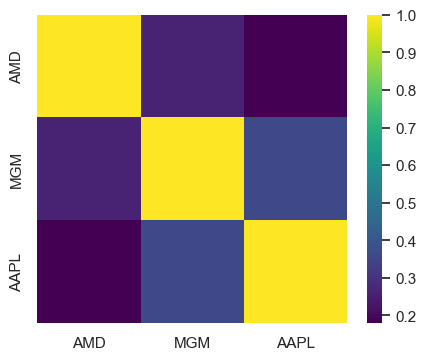

In [77]:
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=False, cmap='viridis',
                xticklabels=True, yticklabels=True)
#plt.title(title)
plt.show()